# F-Praktikum Experiment 108: Simulation of the Physics

This jupyter notebook contains the tasks from the F-Praktikum Experiment 108. 

1. In the first task the trajectory of an electron under the influence of electric and magnetic fields is numerically calculated using the following integration methods:
- Forward Euler
- Predictor-Corrector (Trapezoidal)
- Range Kutta (RK4)

The trajectories on the x-y planes are further plotted to analyze them. The energy along time is plotted for each method as well.

2. In the second task the Montecarlo method is used to calculate the distribution for the resonance mass of the jpsi particle. To do it, two methods are used:
- Hit and miss
- Inverse CDF

The efficiency and accuracy of each method are as well analyzed.

3. In the last task the functions of the first two tasks are used to simulate the decay of a jpsi particle into two muons and their trajectories under a magnetic field.

## Exercise 1: Methods of solving ODE

In [789]:
# Install dependencies
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
GeV_to_J = 1.60218e-10   # [J/GeV]
c    = 299892458         # [m/s]
e    = 1.602e-19         # [C]
q    = [-e, 0, 0]        # electron charge
m    = [511e-6, 0, 0]    # [GeV/c^2]

tmax = 1e-9
dt   = 1e-12

# Initial parameters
t0 = 0                   # [s]

x0 = 0                   # [m]
y0 = 0                   # [m]
z0 = 0                   # [m]

px0 = 1                  # [Gev/c]
py0 = 0                  # [Gev/c]
pz0 = 0                  # [Gev/c]

E0 = np.sqrt(px0**2 + py0**2 + pz0**2 + m[0]**2)


Ex = 10                   # [V/m]
Ey = 0                      # [V/m]
Ez = 0                      # [V/m]
E = [Ex, Ey, Ez]

Bx = 0                   # [T]
By = 0                   # [T]
Bz = 1                   # [T]
B = [Bx, By, Bz]

# Set the initial state vector and the parameters
r0 = np.array([t0, x0, y0, z0, E0, px0, py0, pz0])
par = np.array([q, m, E, B])

In [790]:
def eom(r, par):
    # Unpack the variables from the state vector
    t, x, y, z = r[0], r[1], r[2], r[3]
    En, px, py, pz = r[4], r[5], r[6], r[7]

    # Unpack parameters
    q_array, m_GeV_array, E, B = par

    q = q_array[0]
    m_GeV = m_GeV_array[0]

    m = m_GeV * GeV_to_J / c**2
    px_si = px * GeV_to_J / c
    py_si = py * GeV_to_J / c
    pz_si = pz * GeV_to_J / c

    vx = px_si / m
    vy = py_si / m
    vz = pz_si / m
    Ex, Ey, Ez = E[0], E[1], E[2]
    Bx, By, Bz = B[0], B[1], B[2]

    # Lorent force in SI units
    dpx = q * (Ex + vy * Bz - vz * By)
    dpy = q * (Ey + vz * Bx - vx * Bz)
    dpz = q * (Ez + vx * By - vy * Bx)

    # Convert the force back to GeV/c for updating momentum
    dpx_GeV = dpx / (GeV_to_J / c)
    dpy_GeV = dpy / (GeV_to_J / c)
    dpz_GeV = dpz / (GeV_to_J / c)

    # Return derivatives : [dt/dt, dx/dt, dy/dt, dz/dt, dEn/dt, dpx/dt, dpy/dt, dpz/dt]

    new_par = np.array([1, vx, vy, vz, 0, dpx_GeV, dpy_GeV, dpz_GeV])
    
    return new_par

In [792]:
# Define a function to plot eletrons trajectory
def plot_trajectory(r, xlim, ylim, savefig=False, filename=None):
    # Get the x-y coordinates from the state vector
    x = r[:, 1]
    y = r[:, 2]

    # Plot them
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y, label="Electron's trajectory")

    # Set labels
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    # Set lims
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Save the figure
    if savefig:
        plt.savefig(filename)
        
    plt.grid(True)
    plt.legend()
    plt.show()

In [793]:
# Define a function that plots the energy against time
def E_against_t(r, savefig=False, filename=None):
    # Time
    t = r[:, 0]
    
    # Get the energy from the state vector (which is constant, since it is defined like that in the eom)
    En = r[:, 4]

    # Manually calculate the energy from the momenta
    px, py, pz = r[:, 5], r[:, 6], r[:, 7]
    E = np.sqrt(px**2 + py**2 + pz**2)

    # Plot them
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t, En, label="Conserved energy")
    ax.plot(t, E, label="Numerically calculated energy")

    # Set labels
    ax.set_xlabel("t [s]")
    ax.set_ylabel("E [GeV]")

    # Set lims
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)

    # Save the figure
    if savefig:
        plt.savefig(filename)
        
    plt.grid(True)
    plt.legend()
    plt.show()
    

### Forward Euler

In [791]:
# Euler method
def euler(r0=r0, par=par, tmax=tmax, dt=dt):
    N = int((tmax - r0[0])/dt)        # Number of steps
    r = np.zeros((N, len(r0)))        # Initialization of the trajectory
    r[0] = r0                         # Initial conditions
    
    # Iterate through each time step
    for i in range(N-1):
        r[i+1] = r[i] + dt*eom(r[i], par)

    return r

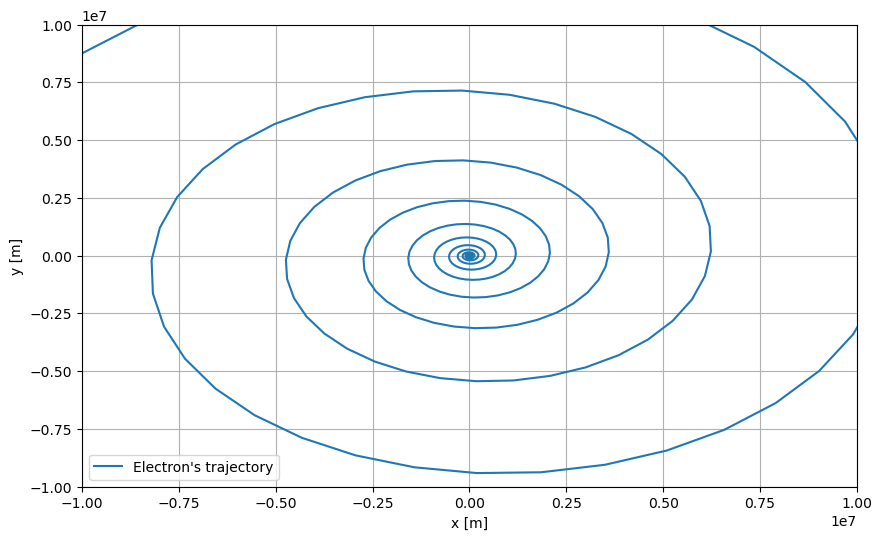

In [803]:
# calculate the electrons trajectory using Forward Euler
r = euler()

# Plot the trajectory
plot_trajectory(r, xlim=[-1e7, 1e7], ylim=[-1e7, 1e7])

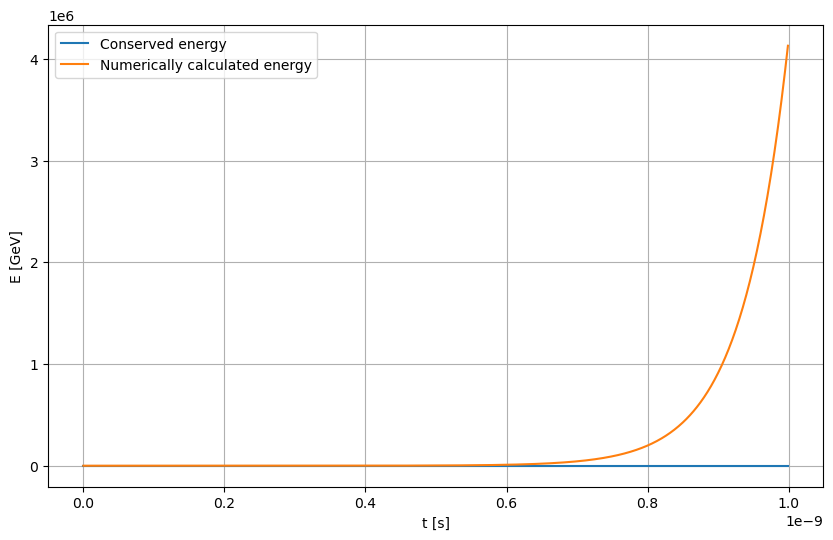

In [795]:
# Plot the energy
E_against_t(r)

### Predictor-corrector

In [804]:
# Predictor correcto method
def predictor_corrector(r0=r0, par=par, tmax=tmax, dt=dt):
    N = int((tmax - r0[0])/dt)        # Number of steps
    r = np.zeros((N, len(r0)))        # Initialization of the trajectory
    r[0] = r0                         # Initial conditions
    
    # Iterate through each time step
    for i in range(N-1):
        r_pred = r[i] + dt*eom(r[i], par)
        r[i+1] = r[i] + 0.5*dt*(eom(r[i], par) + r_pred)

    return r

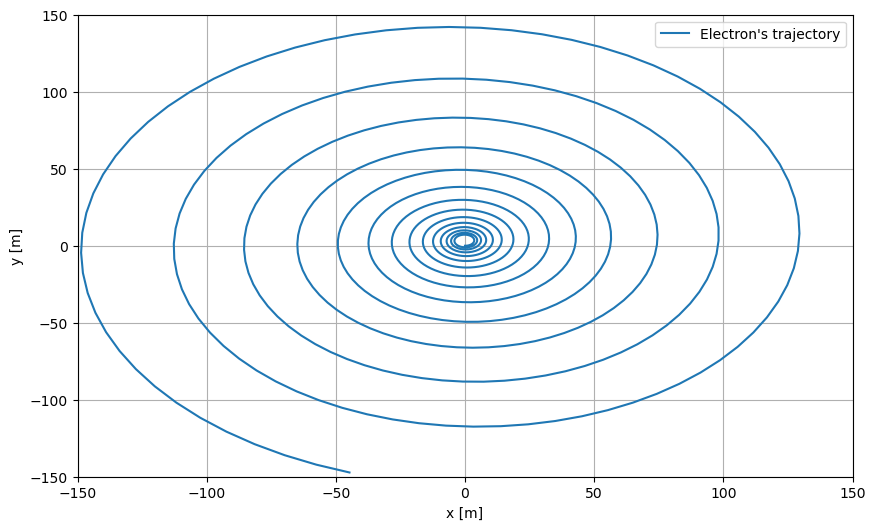

In [805]:
# calculate the electrons trajectory using Forward Euler
r = predictor_corrector()

# Plot the trajectory
plot_trajectory(r, xlim=[-150, 150], ylim=[-150, 150])

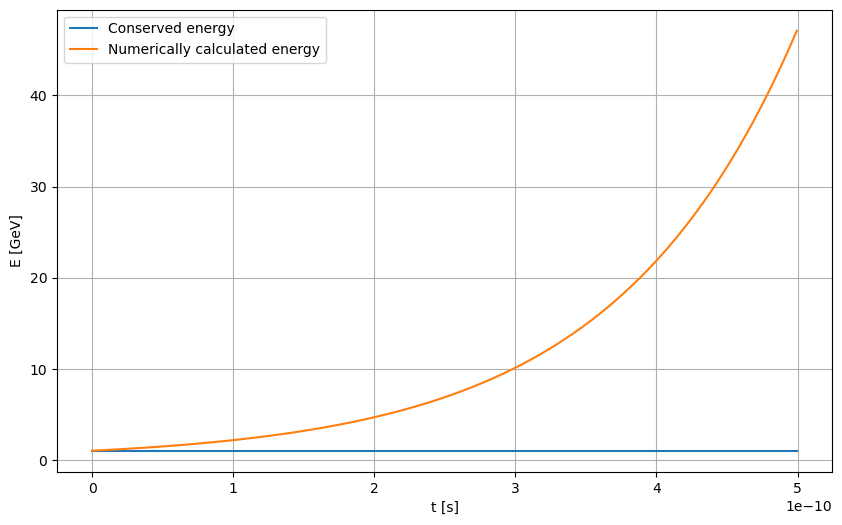

In [806]:
E_against_t(r)

### Runge Kutta

In [218]:
# RK4 method
def runge_kutta_4(r0=r0, par=par, tmax=tmax, dt=dt):
    N = int((tmax - r0[0])/dt)                       # Number of steps
    ts = np.linspace(r0[0], tmax, N) # Time steps
    r = np.zeros((N, len(r0)))        # Initialization of the trajectory
    r[0] = r0                         # Initial conditions
    m_array = par[1]                  # Mass
    m = m_array[0]
    
    # Iterate through each time step
    for i in range(N-1):

        # Calculate the stages
        k1 = dt*eom(r[i], par)
        k2 = dt*eom(r[i] + 0.5*k1, par)
        k3 = dt*eom(r[i] + 0.5*k2, par) 
        k4 = dt*eom(r[i] + k3, par)

        # Calculate the next step
        r[i+1] = r[i] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)

    return r

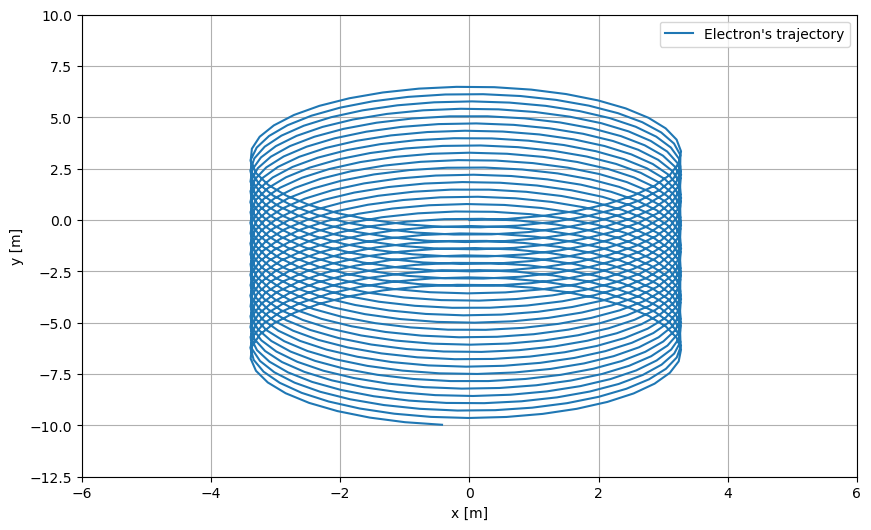

In [817]:
# calculate the electrons trajectory using Forward Euler
r = runge_kutta_4()

# Plot the trajectory
plot_trajectory(r, xlim=[-6, 6], ylim=[-12.5, 10])

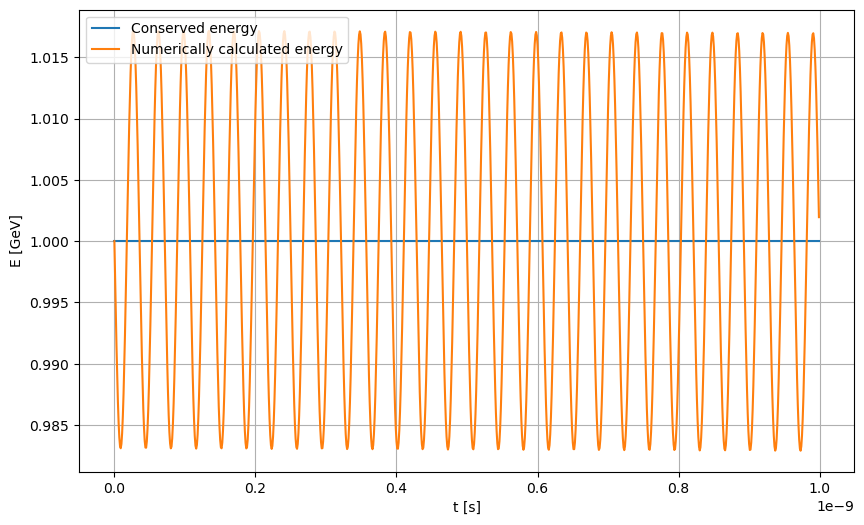

In [818]:
E_against_t(r)

## Exercise 2: MC Simulation of the resonance mass

In [567]:
import pandas as pd

# Load the .dat file
data = pd.read_csv('resonance.dat', delim_whitespace=True)

# Display the data
print(data)

# Access columns
x = data['x']
y = data['y']

       x      y
0   2950   3226
1   2955   3170
2   2960   3198
3   2965   3184
4   2970   3156
5   2975   3212
6   2980   3142
7   2985   3184
8   2990   3198
9   2995   3156
10  3000   3073
11  3005   3184
12  3010   3101
13  3015   3156
14  3020   3031
15  3025   3087
16  3030   3156
17  3035   3017
18  3040   3142
19  3045   3184
20  3050   3184
21  3055   3212
22  3060   3351
23  3065   3615
24  3070   4004
25  3075   4880
26  3080   6507
27  3085   8440
28  3090  11026
29  3095  12291
30  3100  12221
31  3105  10887
32  3110   8495
33  3115   6382
34  3120   4644
35  3125   3629
36  3130   3198
37  3135   2822
38  3140   2809
39  3145   2711
40  3150   2586
41  3155   2753
42  3160   2628
43  3165   2628
44  3170   2544
45  3175   2530
46  3180   2461
47  3185   2656
48  3190   2558
49  3195   2461
50  3200   2544
51  3205   2475
52  3210   2489
53  3215   2461
54  3220   2447
55  3225   2503
56  3230   2489
57  3235   2419
58  3240   2447
59  3245   2336


C:\Users\Asus\AppData\Local\Temp\ipykernel_14972\3785904626.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('resonance.dat', delim_whitespace=True)


### Evaluation functions

In [822]:
# Function to sample the values of a pdf into a histogram
def sample_values(pdf, bins=60):
    # Sort the values into bins
    hist, bin_edges = np.histogram(pdf, bins=bins, density=True)  # Density=True for PDF
    hist_norm = hist / np.sum(hist)
    
    return hist_norm

In [823]:
# Function to calculate the mean squared error
def chi2(sample, data):
    if len(sample) != len(data):
        raise ValueError("Histograms must have the same number of bins")
    
    # Calculate chi2 values for each bin
    chi2_values = (sample - data)**2
    
    # Return the sum of chi2 values
    return sum(chi2_values)

In [824]:
# Function for the efficiency of each method
def efficiency(sample, num_samples):
    return len(sample) / num_samples

In [947]:
def plot_pdf(x, y, pdf, chi2, eff, n_samples, title="Hit and Miss sampling"):
    # Plot the distribution and the pdf
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y/5, label=f'Normalized Distribution (f(x))', color='blue')
    ax.hist(pdf, bins=len(x), density=True, color='orange', alpha=0.6, edgecolor='black', label='Sampled Distribution'  + f"\nn_samples = {n_samples}\n" r'$\chi^2$ = ' + f'{chi2:5f}\n' + r'$\epsilon$ = ' + f'{eff}')
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Hit and miss

In [853]:
# Define the function for the hit and miss method
def hit_and_miss_sampling(y, x, num_samples):
    # Normalize the y-values to get a probability distribution
    y_normalized = y / np.sum(y)

    # Define the range for x and max(f(x))
    x_min, x_max = x.min(), x.max()
    y_max = y_normalized.max()

    accepted_x = []
    
    for _ in range(num_samples):
        # Generate random x within the range of data
        x_rand = np.random.uniform(x_min, x_max)
        # Interpolate y_normalized at x_rand
        y_rand_actual = np.interp(x_rand, x, y_normalized)
        # Generate a random y between 0 and max(f(x))
        y_rand = np.random.uniform(0, y_max)
        
        # Accept or reject
        if y_rand < y_rand_actual:
            accepted_x.append(x_rand)

    # Convert accepted_x to a numpy array
    accepted_x = np.array(accepted_x)

    return accepted_x, y_normalized

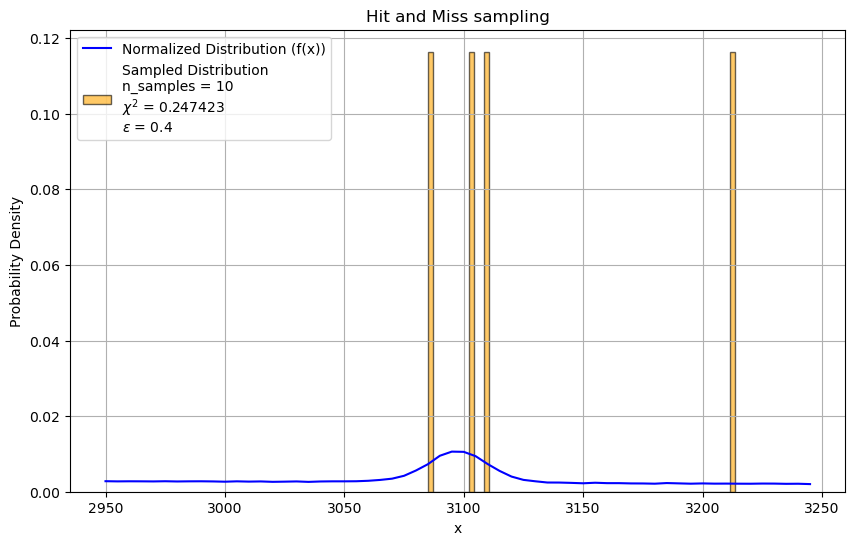

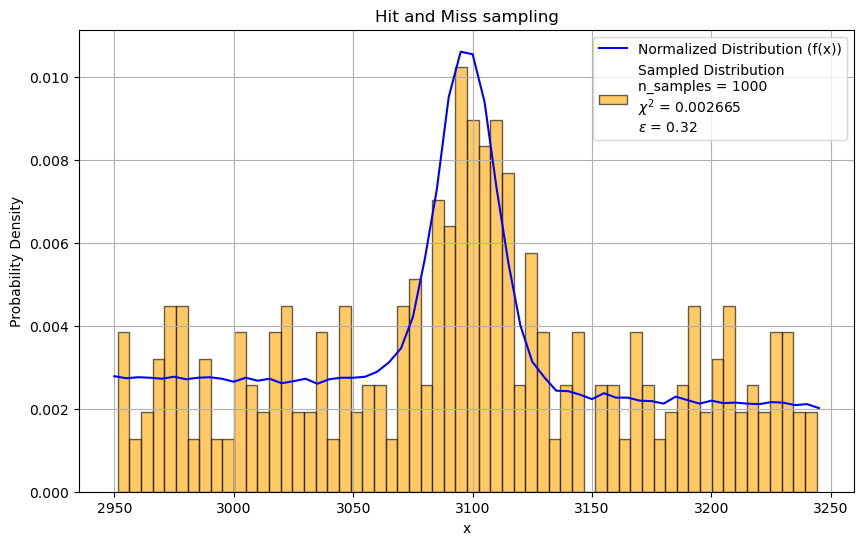

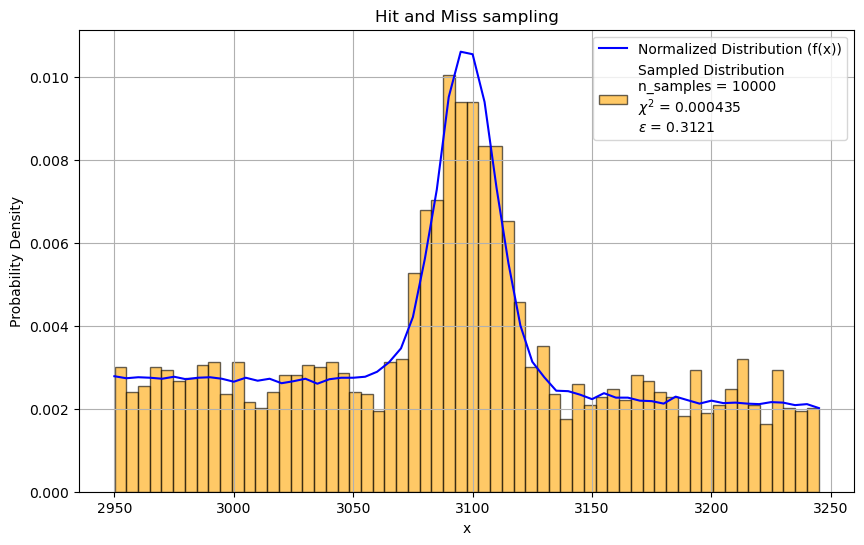

In [854]:
# Calculate the density for 10, 1000 and 10000 samples for the hit and miss method
N_samples = [10, 1000, 10000]

for n_samples in N_samples:
    # Calculate the pdf
    pdf_hm, y_normalized = hit_and_miss_sampling(y, x, n_samples)
    # Sample it
    sample_hm = sample_values(pdf_hm)
    # Calculate the chi2
    chi2_hm = chi2(sample_hm, y_normalized)
    # Calculate the efficiency
    eff_hm = efficiency(pdf_hm, n_samples)
    # Plot
    plot_pdf(x, y_normalized, pdf_hm, chi2_hm, eff_hm, n_samples)

### Inverse CDF

In [435]:
def inverse_cdf_sampling(y, x, n_samples):
    # Normalize the y-values to create a probability distribution
    y_normalized = y / np.sum(y)
    
    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(y_normalized)
    cdf -= cdf.min()  # Normalize to ensure CDF ends at 1
    cdf = cdf / cdf.max()
    
    # Generate random numbers uniformly distributed in [0, 1]
    random_uniform = np.random.uniform(0, 1, size=n_samples)
    
    # Apply the inverse CDF using interpolation
    pdf = np.interp(random_uniform, cdf, x)

    return pdf, cdf

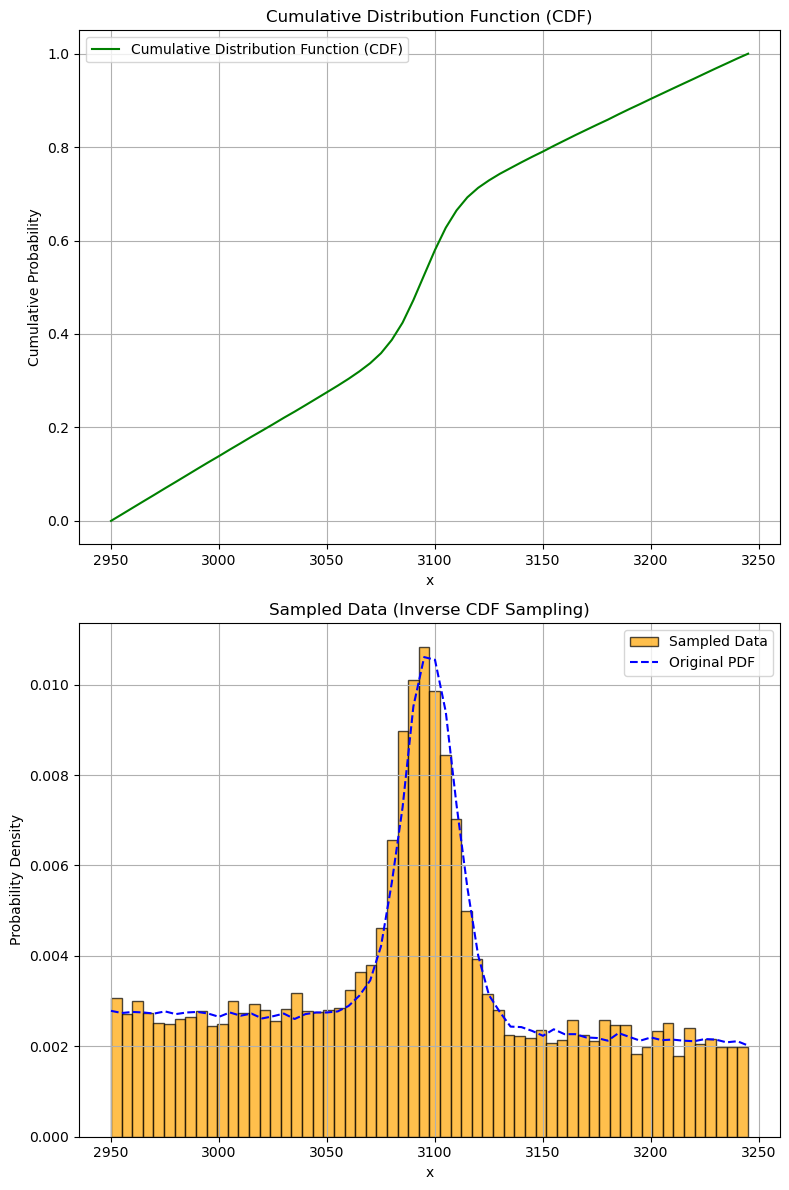

In [436]:
# Calculate the density for 10000 samples
n_samples = 10000
pdf_inv, cdf = inverse_cdf_sampling(y, x, n_samples)

# Plot the original distribution, CDF, and sampled data
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

# Plot the CDF'
ax[0].plot(x, cdf, label='Cumulative Distribution Function (CDF)', color='green')
ax[0].set_title('Cumulative Distribution Function (CDF)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Cumulative Probability')
ax[0].grid(True)
ax[0].legend()

# Plot the sampled data as a histogram
ax[1].hist(pdf_inv, bins=60, density=True, color='orange', edgecolor='black', alpha=0.7, label='Sampled Data')
ax[1].plot(x, y_normalized/5, label='Original PDF', color='blue', linestyle='--')
ax[1].set_title('Sampled Data (Inverse CDF Sampling)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Probability Density')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

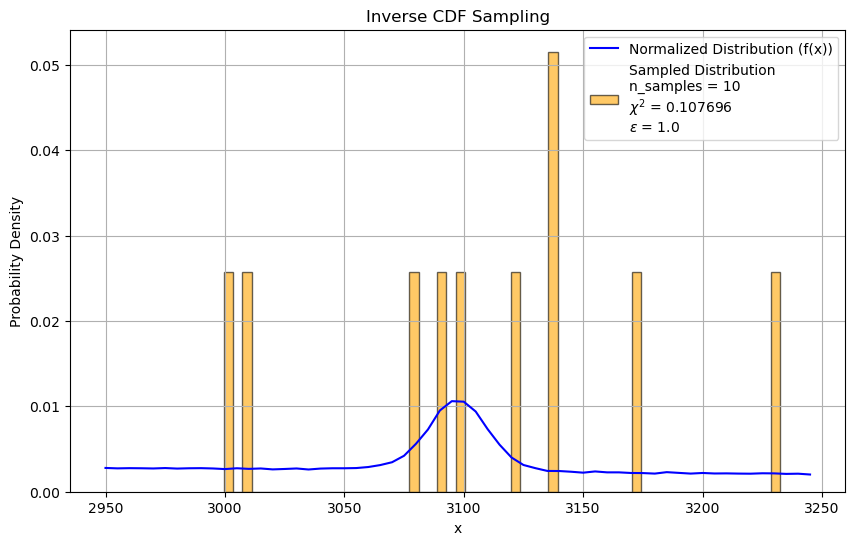

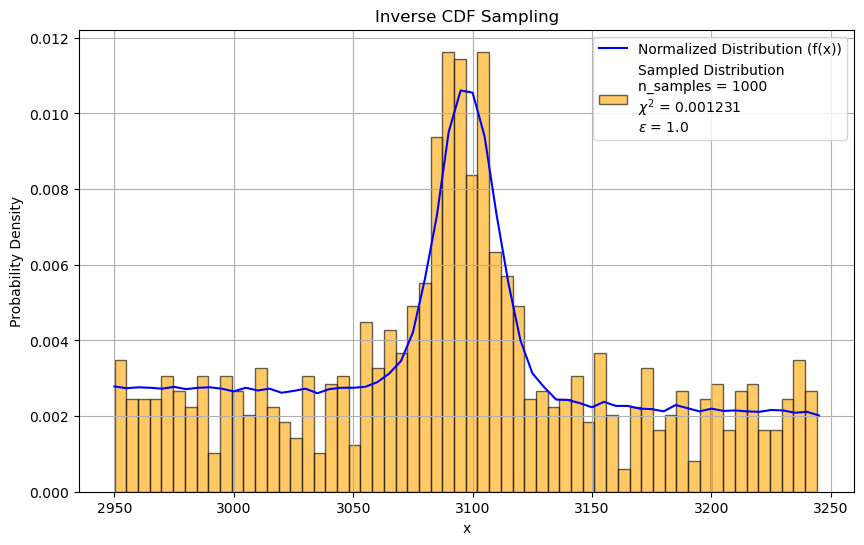

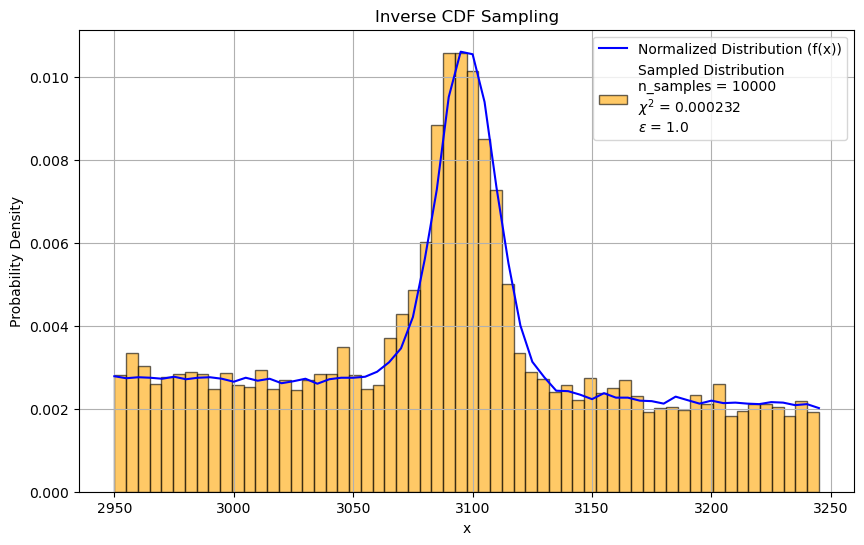

In [948]:
# Calculate the density for 10, 1000 and 10000 samples for the hit and miss method
N_samples = [10, 1000, 10000]
y_normalized = y / sum(y)

for n_samples in N_samples:
    # Calculate the pdf
    pdf_inv, cdf = inverse_cdf_sampling(y, x, n_samples)
    # Sample it
    sample_inv = sample_values(pdf_inv)
    # Calculate the chi2
    chi2_inv = chi2(sample_inv, y_normalized)
    # Calculate the efficiency
    eff_inv = efficiency(pdf_inv, n_samples)
    # Plot
    plot_pdf(x, y_normalized, pdf_inv, chi2_inv, eff_inv, n_samples, title="Inverse CDF Sampling")

## Exercise 3: Simulation of decay and reconstruction of muons momenta

In [504]:
# Function to compute 4-momentum vector with angles, momentum and mass
def four_momentum(m, p, cos_theta, phi):
    theta = acos(cos_theta)

    px = p * sin(theta) * cos(phi)
    py = p * sin(theta) * sin(phi)
    pz = p * cos(theta)
    E = np.sqrt(p**2 + m**2)

    # Return the 4 momentum vector
    return E, px, py, pz

In [459]:
# Function to get angles based on the momentum components
def angles(px, py, pz):
    # Compute the total momentum magnitude p
    p = np.sqrt(px**2 + py**2 + pz**2)

    # Compute cos(theta) = pz/p
    cos_theta = pz/p

    # Compute phi = atan2(py, px) (azimuthal angle in radians)
    phi = np.atan(py, px)

    return cos_theta, phi

In [466]:
# Function to calculate the momentum of the particle based on the circular trajectory in magnetic field given by two state vectors
def momentum_from_circle(point1, point2, q, B):
    t1, x1, y1, z1, E1, px1, py1, pz1 = point1
    t2, x2, y2, z2, E2, px2, py2, pz2 = point2

    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    p1 = np.array([px1, py1, pz1])
    p2 = np.array([px2, py2, pz2])

    # Projection of the momenta on the plane that is perpendicularr to the magnetic field
    B_e = B / np.linalg.norm(B)
    p1_par = np.dot(p1, B_e) * B_e
    p2_par = np.dot(p2, B_e) * B_e
    p1_perp = p1 - p1_par
    p2_perp = p2 - p2_par

    # Calculation of hte distance between points in the plane that is perpendicular to the magnetic field
    d = r2 - r1
    d_perp = d - np.dot(d, B_e) * B_e

    cos_theta = np.dot(p1_perp, p2_perp) / (np.linalg.norm(p1_perp) * np.linalg.norm(p2_perp))

    R = np.linalg.norm(d_perp) / (2 * np.sqrt(abs(1 - abs(cos_theta)) / 2))
    p = np.sqrt(np.linalg.norm(p2_par)**2 + (q * np.linalg.norm(B) * R)**2)

    return R, p

In [906]:
# Function to calculate the radious of the circle given two state vectors
def radius_of_circle(point1, point2, xz=True):
    t1, x1, y1, z1, E1, px1, py1, pz1 = point1
    t2, x2, y2, z2, E2, px2, py2, pz2 = point2

    if xz:
        d = np.sqrt((x2-x1)**2 + (z2-z1)**2) # Just  for this special case on the x-z plane
    else:
        d = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
        
    p1 = np.array([px1, pz1])
    p2 = np.array([px2, pz1])

    p1_magnitude = np.linalg.norm(p1)
    p2_magnitude = np.linalg.norm(p2)

    cos_theta = np.dot(p1, p2) / (p1_magnitude * p2_magnitude)

    R = d / (2 * abs(cos_theta))

    return R

In [470]:
# Function to compute momentum based on the radius of the circle through two points
def momentum_from_radius(R, q, B):
    # Calculate the momentum p using p = qBr
    p = (q * B * R)

    return p

In [532]:
# Define the mass of the mu particles
m_mu = 0.1057  # [GeV/c^2]

In [535]:
# Function to compute the momenta of two muons from the J/psi decay
def jpsi_to_mumu(m_jpsi):
    E_mu = m_jpsi/2 # Energy is half the invariant mass of J/psi
    p_mu = np.sqrt(E_mu**2 - 4*m_mu**2)
    cos_theta = np.random.uniform(-1, 1) # cos(theta) is uniformly distributed between -1 and 1

    theta = np.arccos(cos_theta)
    phi = np.random.uniform(-np.pi, np.pi) # phi is uniformly sampled between -pi and pi

    px = p_mu * np.sin(theta) * np.cos(phi)
    py = p_mu * np.sin(theta) * np.sin(phi)
    pz = p_mu * np.cos(theta)

    # Created muons have an opposite trajectory because the momentum should add to zero (in the center of mass frame) zeros left for the time and position coordinates
    p1 = np.array([0, 0, 0, 0, E_mu, px, py, pz])
    p2 = np.array([0, 0, 0, 0, E_mu, -px, -py, -pz])

    charge_muon_1 = 1 if np.random.rand() < 0.5 else -1
    charge_muon_2 = -charge_muon_1

    if charge_muon_1 == -1: # Always return negatively charge muon first
        return p1, p2
    else:
        return p2, p1

In [664]:
# Function to compute the invariant mass of J/psi from two muon 4-momenta
def jpsi_from_mumu(p1, p2):

    E = p1[4] + p2[4]
    px = p1[5] + p2[5]
    py = p1[6] + p2[6]
    pz = p1[7] + p2[7]

    p = np.sqrt(px**2 + py**2 + pz**2)

    M_mumu = np.sqrt(E**2 - p**2)

    return M_mumu

In [910]:
# Define a function to calculate the momenta after decay and after trajectory
def muon_momenta(t0=tmu0, x0=xmu0, y0=ymu0, z0=zmu0, par_minus=par_minus, par_plus=par_plus, bin_contents=y, bin_positions=x, n_samples=10000):
    # Calculate the jpsi resonance mass distribution
    pdf_inv, cdf = inverse_cdf_sampling(bin_contents, bin_positions, n_samples)
    
    # Pick randomly one value for the mass
    M_mumu = np.random.choice(pdf_inv) / 1000  # [GeV/C^2]
    
    # Compute the momenta of the two muons from the mass
    p_minus, p_plus = jpsi_to_mumu(M_mumu)
    
    # Calculate the absolute values of the momenta after the decay
    p_minus_decay = np.sqrt(p_minus[5]**2 + p_minus[7]**2)
    p_plus_decay = np.sqrt(p_plus[5]**2 + p_plus[7]**2)
    
    # Define the intial state vector
    r0_minus = np.copy(p_minus)
    r0_plus = np.copy(p_plus)
    r0_minus[0], r0_minus[1], r0_minus[2], r0_minus[3] = t0, x0, y0, z0
    r0_plus[0], r0_plus[1], r0_plus[2], r0_plus[3] = t0, x0, y0, z0
    
    # Simulate the trajectory of the muons 
    r_minus = runge_kutta_4(r0=r0_minus, par=par_minus, tmax=tmumax, dt=dtmu)
    r_plus = runge_kutta_4(r0=r0_plus, par=par_plus, tmax=tmumax, dt=dtmu)
    
    # Store the first and last point of the trajectory
    points_minus = np.array([r_minus[0], r_minus[-1]])
    points_plus = np.array([r_plus[0], r_plus[-1]])
    
    # Get the radii of the circles
    R_minus = radius_of_circle(points_minus[0], points_minus[1])
    R_plus = radius_of_circle(points_plus[0], points_plus[1])
    
    # Caclulate the momenta from the radii (e = 1 in natural units)
    p_minus_radius = momentum_from_radius(R_minus, 1, np.linalg.norm(par_minus[-1]))
    p_plus_radius = momentum_from_radius(R_plus, 1, np.linalg.norm(par_plus[-1]))
    
    # Calculate the error of the momenta dp/p compared to the initial momentum after the decay
    p_minus_err = abs(p_minus_radius - p_minus_decay)/p_minus_decay
    p_plus_err = abs(p_plus_radius - p_plus_decay)/p_plus_decay

    # Reconstructed mass
    M_mumu_reconstructed = jpsi_from_mumu(r_minus[-1], r_plus[-1])
    M_mumu_err = abs(M_mumu_reconstructed - M_mumu) / M_mumu

    print(f"J/psi mass : {M_mumu:.3f} GeV/c^2")
    print(f"J/psi reconstructed mass: {M_mumu_reconstructed:.3f} GeV/c^2")
    print(f"Relative Mass Error : {M_mumu_err*100:.2f} %")
    print("--------------------------------------------------------")
    print(f"Muon Momentum after decay : {p_minus_decay:.2f} Gev/c")
    print(f"Muon Momentum after trajectory : {p_minus_radius:.2f} Gev/c")
    print(f"Relative Momenta Error : {p_minus_err*100:.2f} %")


    return r_minus, r_plus

In [911]:
# Create a function to plot the trajectories of the muons on the x-z plane
def plot_muons(xlim=[-8, 8], ylim=[-14, 14], r_minus=r_minus, r_plus=r_plus, savefig=False, filename=None):
    # Obtrain the coordinates of the (x-z) plane from the state vector
    x_minus = r_minus[:, 1]
    z_minus = r_minus[:, 3]
    
    x_plus = r_plus[:, 1]
    z_plus =  r_plus[:, 3]
    
    # Plot them
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x_minus, z_minus, label=r"$\mu_-$ trajectory", c="blue")
    ax.plot(x_plus, z_plus, label=r"$\mu_+$ trajectory", c="red")

    # Label the axes
    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")

    # Set the lims
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.grid(True)
    plt.legend()

    # Save the figure
    if savefig:
        plt.savefig(filename)
    
    plt.show()

J/psi mass : 3.109 GeV/c^2
J/psi reconstructed mass: 2.991 GeV/c^2
Relative Mass Error : 3.78 %
--------------------------------------------------------
Muon Momentum after decay : 0.75 Gev/c
Muon Momentum after trajectory : 2.56 Gev/c
Relative Momenta Error : 240.50 %


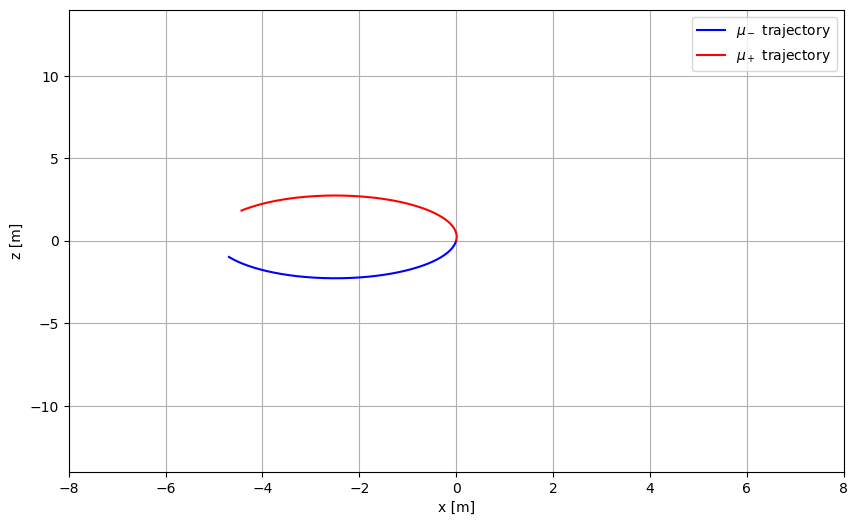

In [945]:
# SImulation of the J/psi decay to two muons and reconstruction of J/psi based on tracks of muons in the magnetic fiel

tmu0, xmu0, ymu0, zmu0 = 0, 0, 0, 0
tmumax, dtmu = 3e-9, 1e-11  # [s]
E_exp = np.array([0, 0, 0])
B_exp = np.array([0, 1, 0])
q_minus = np.array([-e, 0, 0])
q_plus = np.array([e, 0, 0])

# Store the mass into an array
M_mu = np.array([m_mu, 0, 0])

# Calculate parameters
par_minus = np.array([q_minus, M_mu, E_exp, B_exp])
par_plus = np.array([q_plus, M_mu, E_exp, B_exp])

# Calculate and plot the trajectories of the muons
r_minus, r_plus = muon_momenta()
plot_muons(r_minus=r_minus, r_plus=r_plus)